# Detecting anomalies in your images using the resnet50 Pipeline 

The following tutorial shows you 

1. How to deploy a wallaroo pipeline using faster rcnn mobilenet model created in step 2
2. Create a post-process-anomoly-detection.py file and add logic for detecting anomolies
3. We will add the post-process-anomoly-detection.py as a step in the pipeline
2. Then run inference on a sample image
3. Draw the detected objects, their bounding boxes, their classifications, and the confidence of the classifications on the provided image.
4. Note how many anomolies were detected



In [1]:
import torch
import pickle
import wallaroo
import os
import numpy as np
import json
import requests
import time
import pandas as pd

In [2]:
wl = wallaroo.Client()

In [3]:
model_name = 'resnet50'
model = wl.upload_model(model_name, "models/frcnn-resnet.pt.onnx")

Next we will add our post processing anomoly detection file called post-process-anomoly-detection.py.  Predictions that are lower than 75% we will consider anomalies that need to be inspected.

In [4]:
module_anomoly_detection = wl.upload_model("post-process-anomoly-detection", "./post-process-anomoly-detection.py").configure('python')

In [5]:
deployment_config = wallaroo.DeploymentConfigBuilder().replica_count(1).cpus(1).memory("8Gi").build()

In [6]:
pipeline_name = 'a-resnet-pp'
pipeline = wl.build_pipeline(pipeline_name) \
            .add_model_step(model) \
            .add_model_step(module_anomoly_detection)

pipeline.deploy(deployment_config = deployment_config)

 ok


name,a-resnet-pp
created,2022-11-04 12:14:54.488127+00:00
last_updated,2022-12-14 13:21:25.306497+00:00
deployed,True
tags,
steps,resnet50


In [7]:
time.sleep(5) # needed to allow the pipeline to settle in.
url = pipeline._deployment._url()
print(url)

http://engine-lb.a-resnet-pp-655:29502/pipelines/a-resnet-pp


## Test the pipeline by running inference on a sample image

### Initialize some Vars

Initialize the COCO Classes, meaning the classificaitons found on the images and what the default width and height that the mobilnet model requires the images to be in order to properly run inference.

In [8]:

from CVDemoUtils import CVDemo

# set the device we will be using to run the model
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# The set of COCO classifications
CLASSES = pickle.loads(open("models/coco_classes.pickle", "rb").read())

# Unique colors for each identified COCO class
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

# The size the image will be resized to
width = 640
height = 480

# Only objects that have a confidence > confidence_target will be displayed on the image
confidence_target = 0.75
cvDemo = CVDemo()
cvDemo.DEBUG = False


### Prepare input image

Next we will load a sample image and resize it to the width and height required for the object detector.

We will convert the image to a numpy ndim array and add it do a dictionary

In [9]:
imagePath = 'data/images/input/example/example_01.jpg'

# The image width and height needs to be set to what the model was trained for.  In this case 640x480.
tensor, resizedImage = cvDemo.loadImageAndResize(imagePath, width, height)

# get npArray from the tensorFloat
npArray = tensor.cpu().numpy()

#creates a dictionary with the wallaroo "tensor" key and the numpy ndim array representing image as the value.
dictData = {"tensor": npArray.tolist()}


# Run inference using the SDK 

Now lets have the model detect the objects on the image by running inference and extracting the results 

In [15]:

startTime = time.time()
infResults = pipeline.infer(dictData)
endTime = time.time()

results = infResults[0].raw
results['original_data'] = None  # We are removing the input image json.  Not needed

### Extract Classifications and Confidences

Next we will print the COCO classification of each identified objects and the percentage classification confidence.  

# Extract our Anomalies

In [16]:
anomolyClasses = results['outputs'][0]['Json']['data'][0]['anomaly-classes']
anomolyConfidences = results['outputs'][0]['Json']['data'][0]['anomaly-confidences']
anomolyBoxes = results['outputs'][0]['Json']['data'][0]['anomaly-boxes']


Lets build our table of anomalies

In [19]:
anomolyDf = pd.DataFrame(columns=['classification','confidence','x','y','width','height'])
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.float_format = '{:.2%}'.format

anomolyDf[['x', 'y','width','height']] = pd.DataFrame(anomolyBoxes)

#classes = outputs[1]['Int64']['data']
#confidences = outputs[2]['Float']['data']

idx = 0 
cocoClasses = cvDemo.getCocoClasses()
for idx in range(0,len(anomolyClasses)):
    anomolyDf['classification'][idx] = cocoClasses[anomolyClasses[idx]] # Classes contains the 80 different COCO classificaitons
    anomolyDf['confidence'][idx] = anomolyConfidences[idx]
anomolyDf

,classification,confidence,x,y,width,height
0,person,74.41%,158,261,180,282
1,person,26.05%,103,258,121,278
2,person,8.07%,126,259,147,280
3,person,5.20%,402,273,421,291


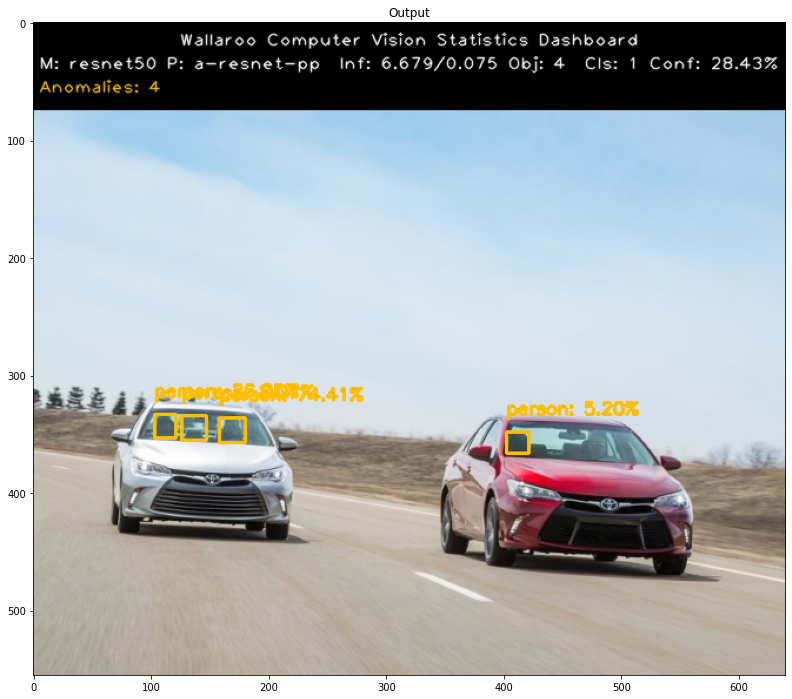

In [20]:
# Reload the sample image
tensor, resizedImage = cvDemo.loadImageAndResize(imagePath, width, height)

amber = (0,191,255)
red = (0,0,255)
blue = (255,0,0)
black = (0,0,0)

results = {
    'model_name' : model_name,
    'pipeline_name' : pipeline_name,
    'width': width,
    'height': height,    'image' : resizedImage,
    'classes' : anomolyClasses,
    'confidences' : anomolyConfidences,
    'anomaly-count' : len(anomolyConfidences),
    'boxes' : anomolyBoxes,
    'confidence-target' : 0.0,
    'inference-time': (endTime-startTime),
    'onnx-time' : int(results['elapsed']) / 1e+9,                
    'color': CVDemo.AMBER
}

image = cvDemo.drawAndDisplayDetectedObjectsWithClassification(results)

In [ ]:

pipeline.undeploy()
#for d in wl.list_deployments():
#    d.undeploy()
    